In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025-bike-availability-prediction/sample_submission_2025.csv
/kaggle/input/2025-bike-availability-prediction/metadata_sample_submission_2025.csv


In [2]:
import os

# Mapeo de números de mes a nombres en catalán
i2m = list(zip(range(1, 13), ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 
                              'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']))

# Definir el rango de años y meses deseados
years_months = [(2022, range(8, 13)),  # Agosto-Diciembre 2022
                (2023, range(1, 6))]   # Enero-Mayo 2023

for year, months in years_months:
    for month in months:
        month_name = i2m[month - 1][1]  # Obtener el nombre del mes en catalán
        
        # Descargar el archivo
        os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
        
        # Extraer en la carpeta de entrenamiento
        os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z' -o./data/training")
        
        # Eliminar el archivo comprimido para ahorrar espacio
        os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")


In [2]:
df_stations = pd.read_csv("/kaggle/input/estacions/Informacio_Estacions_Bicing_2025.csv")
df_barça = pd.read_excel("/kaggle/input/bara-lliga-22-23/Partidos Bara Jornada 22-23.xlsx", header=1)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/estacions/Informacio_Estacions_Bicing_2025.csv'

In [5]:
training_path = "/kaggle/working/data/training"
# Leer path de todos los archivos de training y df de estaciones
file_list = [os.path.join(training_path, f) for f in os.listdir(training_path) if f.endswith(".csv")]



In [97]:
df_barça['Fecha_Hora'] = pd.to_datetime(df_barça['Fecha'].astype(str) + ' ' + df_barça['Hora'].astype(str))
# Crear una columna "impacto_partido" para identificar los registros dentro del rango de partido
def marcar_impacto_partido(row, df_barça):
    for _, partido in df_barça.iterrows():
        partido_inicio = partido['Fecha_Hora']
        partido_fin = partido_inicio + pd.Timedelta(hours=3)  # 3 horas después del inicio del partido
        partido_inicio_menos_2 = partido_inicio - pd.Timedelta(hours=2)  # 2 horas antes del inicio

        if partido_inicio_menos_2 <= row['Fecha_Hora'] <= partido_fin:
            return True, partido_inicio, partido['Ciudad'], partido['Rival'], partido['Res.']
    
    return False, None, None, None, None



In [98]:
def construct_input(base, stations, barça):
    base['last_reported'] = pd.to_datetime(base['last_reported'], unit='s')
    base['Fecha_Hora'] = base['last_reported'].dt.floor('h')
    df = base.sort_values('last_reported').groupby(['station_id', 'Fecha_Hora']).first().reset_index()
    df = df.merge(stations[['station_id', 'capacity']], on='station_id', how='left')
    df['percentage_docks_available'] = df['num_docks_available'] / df['capacity']
    station_ids = [199, 310, 311, 312, 431] #las 5 estaciones mas cercanas al campo del barça
    df = df[df['station_id'].isin(station_ids)]
    # Aplicar la función a cada fila de df
    df['impacto_partido'], df['hora_inicio'], df['local_visitante'], df['rival'], df['resultado'] = zip(*df.apply(marcar_impacto_partido, axis=1, df_barça=df_barça))
    return df[['station_id','Fecha_Hora','percentage_docks_available','impacto_partido','hora_inicio','local_visitante','rival','resultado']]

In [99]:
# Leer, limpiar cada archivo y juntarlo luego en un solo df
df = pd.concat((construct_input(pd.read_csv(f), df_stations, df_barça) for f in file_list), ignore_index=True)

In [89]:
df_local = df[df['local_visitante'] == 'C']

In [93]:
# Ordenar por 'station_id' y 'Fecha_Hora' para asegurarnos de que las horas estén en orden
df_local = df_local.sort_values(by=['station_id', 'Fecha_Hora'])

# Crear un identificador único para cada partido (por ejemplo, 'station_id' y 'hora_inicio')
df_local['partido_id'] = df_local['station_id'].astype(str) + df_local['hora_inicio'].astype(str)

# Asignar los valores -2, -1, 0, 1, 2, 3 a cada uno de los registros de cada partido
df_local['franja_horaria'] = df_local.groupby('partido_id').cumcount().map({0: -2, 1: -1, 2: 0, 3: 1, 4: 2, 5: 3})

<ipython-input-96-8a64bb4a2f4c>:17: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.lineplot(data=df_media, x='franja_horaria', y='percentage_docks_available', hue='station_id',
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to sil

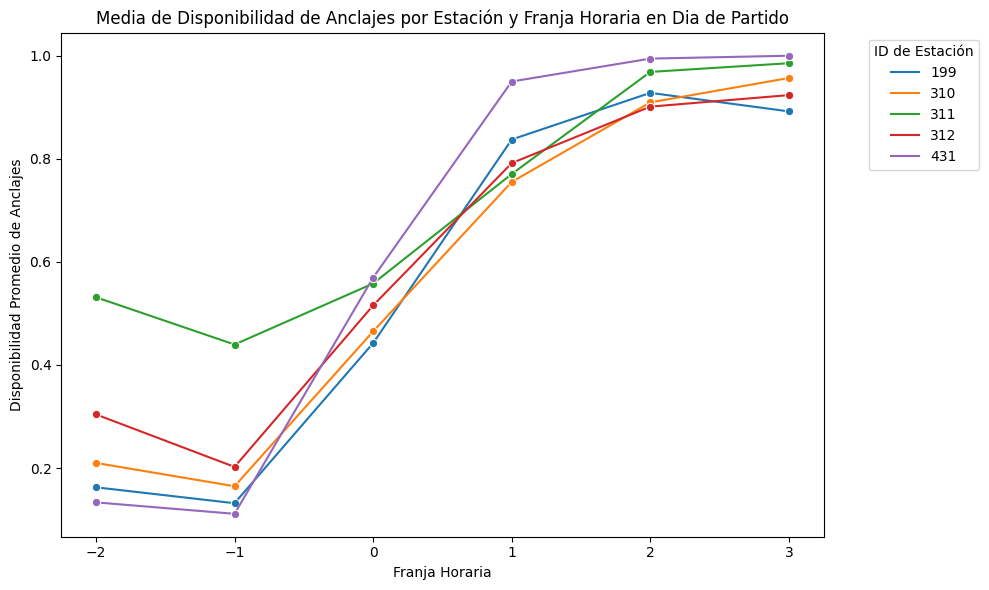

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calcular la media de 'percentage_docks_available' para cada 'station_id' y 'franja_horaria'
df_media = df_local.groupby(['station_id', 'franja_horaria'])['percentage_docks_available'].mean().reset_index()


# Definir colores personalizados para cada estación (asegurándote de tener tantos colores como estaciones)
colores_personalizados = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Usamos seaborn para crear el gráfico de líneas con la paleta de colores personalizada
sns.lineplot(data=df_media, x='franja_horaria', y='percentage_docks_available', hue='station_id', 
             marker='o', palette=colores_personalizados)


# Personalizar el gráfico
plt.title('Media de Disponibilidad de Anclajes por Estación y Franja Horaria en Dia de Partido')
plt.xlabel('Franja Horaria')
plt.ylabel('Disponibilidad Promedio de Anclajes')
plt.legend(title='ID de Estación', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()